<a href="https://colab.research.google.com/github/karencfisher/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [55]:
df.head()

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,Donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,3.80,NaN,Scott,good fries: 4/5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Oscar's Mexican food,California,1/24/2016,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,3.00,NaN,Scott,Fries: 3/5; too little meat,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Oscar's Mexican food,Carnitas,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,3.00,NaN,Emily,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oscar's Mexican food,Carne asada,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,3.75,NaN,Ricardo,Go to average burrito place like Rigoberto's i...,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pollos Maria,California,1/27/2016,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,4.20,NaN,Scott,NaN,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [60]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [61]:
df.shape

(421, 59)

In [62]:
df.describe(exclude='number')

,Burrito,Date,Chips,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
count,421,421,26,33,7,179,158,154,159,127,92,51,21,21,6,36,35,11,7,7,1,8,38,7,15,17,4,7,2,4,4,1,5,3,3,2,13,3,1,421
unique,5,169,4,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,2,1,2
top,California,8/30/2016,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,False
freq,169,29,21,33,5,137,127,114,128,102,67,36,20,17,4,26,27,9,5,4,1,6,33,6,9,9,3,5,2,4,4,1,5,3,3,2,13,2,1,239


Since our own use for the Date feature will be to split the dataset into train/validation/test sets, and it belongs no place in calculating the target value, we'll convert it into just the years. After the split we'll drop it out altogether.

In [0]:
df['Date'] = pd.to_datetime(df['Date']).dt.year

In [64]:
df['Date'].unique()

array([2016, 2026, 2011, 2015, 2017, 2018, 2019])

In [65]:
df['Date'].value_counts()

2016    296
2017     85
2018     27
2019     10
2026      1
2015      1
2011      1
Name: Date, dtype: int64

Whoa, 2026? Did Doc and Marty grab a Burrito on the way and reported their findings?

In [66]:
df.describe()

,Date,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso
count,421.000000,87.000000,87.000000,414.000000,418.000000,22.000000,22.000000,283.000000,281.000000,281.000000,421.000000,401.000000,407.000000,418.000000,412.000000,419.000000,396.000000,419.000000,418.000000,0.0
mean,2016.410926,3.887356,4.167816,7.067343,3.495335,546.181818,0.675277,20.038233,22.135765,0.786477,3.519477,3.783042,3.620393,3.539833,3.586481,3.428998,3.371970,3.586993,3.979904,NaN
std,0.896965,0.475396,0.373698,1.506742,0.812069,144.445619,0.080468,2.083518,1.779408,0.152531,0.794438,0.980338,0.829254,0.799549,0.997057,1.068794,0.924037,0.886807,1.118185,NaN
min,2011.000000,2.500000,2.900000,2.990000,0.500000,350.000000,0.560000,15.000000,17.000000,0.400000,1.000000,1.000000,1.000000,1.000000,0.500000,0.000000,0.000000,1.000000,0.000000,NaN
25%,2016.000000,3.500000,4.000000,6.250000,3.000000,450.000000,0.619485,18.500000,21.000000,0.680000,3.000000,3.000000,3.000000,3.000000,3.000000,2.600000,3.000000,3.000000,3.500000,NaN
50%,2016.000000,4.000000,4.200000,6.990000,3.500000,540.000000,0.658099,20.000000,22.000000,0.770000,3.500000,4.000000,3.800000,3.500000,4.000000,3.500000,3.500000,3.800000,4.000000,NaN
75%,2017.000000,4.000000,4.400000,7.880000,4.000000,595.000000,0.721726,21.500000,23.000000,0.880000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,NaN
max,2026.000000,4.500000,5.000000,25.000000,5.000000,925.000000,0.865672,26.000000,29.000000,1.540000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN


In [67]:
df.isnull().sum()

Burrito             0
Date                0
Yelp              334
Google            334
Chips             395
Cost                7
Hunger              3
Mass (g)          399
Density (g/mL)    399
Length            138
Circum            140
Volume            140
Tortilla            0
Temp               20
Meat               14
Fillings            3
Meat:filling        9
Uniformity          2
Salsa              25
Synergy             2
Wrap                3
Unreliable        388
NonSD             414
Beef              242
Pico              263
Guac              267
Cheese            262
Fries             294
Sour cream        329
Pork              370
Chicken           400
Shrimp            400
Fish              415
Rice              385
Beans             386
Lettuce           410
Tomato            414
Bell peper        414
Carrots           420
Cabbage           413
Sauce             383
Salsa.1           414
Cilantro          406
Onion             404
Taquito           417
Pineapple 

###That's a lot of NaNs. A veritable NaN burrito, one may say...

I am trying to look more closely at how to work with missing data. One thing, in this case, tracing the origin of this data set from a spreach sheet.

It turns out a lot of the categorical features are binary, x (both upper and lower case) or NaN. Like a check list. Ingredient is there, or not. (It is converted from a spread sheet, in which cells were either marked by an 'x' or left blank.) So first step is to make all the 'x' characters one case, and then replace the NaN's with 0, and recast them as integers. 

In [68]:
df.replace(['X', 'x'], '1', inplace=True)

# Find the object columns. All except first 3 are ones we want to change
columns = df.select_dtypes(include='O').columns.tolist()
columns = columns[3:] 

df[columns] = df[columns].fillna('0')
df[columns] = df[columns].astype('int')
df[columns]

,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
419,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
420,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
421,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Mass and density, as intriguing they may be, are 97% missing values
df.drop(['Mass (g)', 'Density (g/mL)'], axis=1, inplace=True)

# I'm also dropping Queso as it has no information (100% NaN)
df.drop(columns=['Queso'], inplace=True)

Whittle away first the remaining categorical categories with NaNs. Chips and Unreliable are 94% and 92% NaN, so meaningless to impute them. So drop them.

In [70]:
df[df.select_dtypes(include='O').columns].isnull().sum()

Burrito         0
Chips         395
Unreliable    388
dtype: int64

In [0]:
df.drop(['Chips', 'Unreliable'], axis=1, inplace=True)

Numeric features

In [72]:
df[df.select_dtypes(include='float').columns].isnull().sum()

Yelp            334
Google          334
Cost              7
Hunger            3
Length          138
Circum          140
Volume          140
Tortilla          0
Temp             20
Meat             14
Fillings          3
Meat:filling      9
Uniformity        2
Salsa            25
Synergy           2
Wrap              3
dtype: int64

Yelp and Google are reviews, and their absence might be significant. So instead of dropping or imputing them, I'll make them 0. No one felt need to review them perhaps? The rest we'll impute. 

In [0]:
columns = df.select_dtypes(include='float').columns[:2].tolist()
df[columns] = df[columns].fillna(0)

But also length, Circumference, and Volume are related variables. The volume of a cylinder (which burritos approximate) is:

\begin{align}V = (C / 4\pi)L\end{align}

So assuming that the three features are colinear, and we can keep just one: Volume. 

In [0]:
df.drop(['Circum', 'Length'], axis=1, inplace=True)

And Burrito has to be numerically encoded.

In [0]:
df['Burrito'] = df['Burrito'].astype('category').cat.codes

Are "Meat" and "Meat:Filling" synonymous? I guess not.

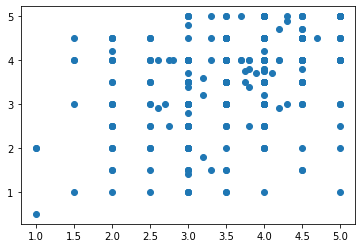

In [76]:
import matplotlib.pyplot as plt
plt.scatter(df['Meat'], df['Meat:filling']);

In [77]:
df.sample(5)

,Burrito,Date,Yelp,Google,Cost,Hunger,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
374,3,2017,0.0,0.0,7.10,3.0,0.81,3.5,5.0,4.0,4.0,4.5,4.75,3.75,4.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
25,3,2016,4.5,4.9,6.00,3.5,NaN,2.5,2.5,3.0,4.0,4.0,4.00,3.00,3.5,1.5,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
394,1,2018,0.0,0.0,8.99,4.0,1.05,4.5,4.5,4.0,4.0,3.0,4.00,3.50,4.0,3.0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
206,3,2016,0.0,0.0,7.50,3.8,0.94,3.8,4.0,4.0,4.0,4.0,4.00,4.50,4.5,4.5,0,0,0,0,1,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
380,3,2017,0.0,0.0,8.50,3.5,0.88,4.0,4.0,4.0,4.5,4.2,4.50,4.00,4.5,4.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True


Now we can begin with the modelling. Will do remaining imputing along the way.

In [0]:
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

### Split into training, validation, and testing datasets

In [79]:
# Now split train/validate/test (up to 2016, 2017, 2018 and on)
df_train = df[df['Date'] <= 2016]
df_val = df[df['Date'] == 2017]
df_test = df[df['Date'] >= 2018]

df_train.shape, df_val.shape, df_test.shape

((298, 52), (85, 52), (38, 52))

In [0]:
# Now drop the date feature altogether
df_train.drop('Date', axis=1, inplace=True)
df_val.drop('Date', axis=1, inplace=True)
df_test.drop('Date', axis=1, inplace=True)

In [0]:
# And further split into X and y sets for each. 
def XySplit(df, target):
  X = df.drop(target, axis=1)
  y = df[target]
  return X, y

In [0]:
X_train, y_train = XySplit(df_train, 'Great')
X_val, y_val = XySplit(df_val, 'Great')
X_test, y_test = XySplit(df_test, 'Great')

### Construct a baseline.

Which is the majority case?

In [83]:
y_train.value_counts()

False    176
True     122
Name: Great, dtype: int64

OK, I guess we should predict every burrito will fail? That seems heartless, to say the least. But in the interests of science...

In [0]:
# Fabricate a dummy y_hat array
from statistics import mode

def dummyModel(y_actual):
  '''
  Determine the majority class and build dummy 'predictions'.
  '''
  # get majority class
  dummy = mode(y_actual)

  # Build and return the array of 'predictions'  
  return [dummy] * len(y_actual)

In [85]:
y_train_dummy = dummyModel(y_train)
print(len(y_train_dummy))
y_train_dummy[:5]

298


[False, False, False, False, False]

In [86]:
train_base_accuracy = accuracy_score(y_train, y_train_dummy)
print(f'Accuracy of our training base model = {train_base_accuracy * 100}%')

Accuracy of our training base model = 59.06040268456376%


In [87]:
# And try on the validate set too
y_val_dummy = dummyModel(y_val)
val_base_accuracy = accuracy_score(y_val, y_val_dummy)
print(f'Accuracy of our validation base model = {val_base_accuracy * 100}%')

Accuracy of our validation base model = 55.294117647058826%


###Imputation of the remaining features with NaNs

In [0]:
imputer = SimpleImputer()
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val_imp = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

# Ready for final test
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [89]:
X_train_imp.sample(10)

,Burrito,Yelp,Google,Cost,Hunger,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
215,3.0,0.0,0.0,7.500000,3.0,0.60000,2.5,2.50000,3.00,2.0,2.00,1.0,5.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158,1.0,0.0,0.0,6.250000,3.0,0.86000,3.8,1.30000,3.50,3.5,4.50,4.5,3.5,4.0,5.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140,3.0,0.0,0.0,6.000000,3.0,0.77092,4.0,3.50000,4.00,4.0,2.00,4.0,4.0,4.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180,3.0,4.0,3.9,4.990000,3.5,0.66000,3.0,3.00000,3.00,3.0,2.50,2.0,2.5,3.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275,1.0,0.0,0.0,6.250000,4.0,0.51000,2.5,4.00000,3.75,4.0,3.75,5.0,4.0,4.0,5.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142,3.0,4.0,4.2,7.900000,3.5,0.75000,3.5,4.50000,4.50,4.0,1.50,1.5,3.0,4.0,5.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,3.0,0.0,0.0,8.000000,3.0,0.77092,3.0,3.70636,1.00,2.0,2.00,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,1.0,0.0,0.0,7.500000,5.0,0.72000,3.5,3.00000,2.00,3.0,3.00,2.0,4.0,2.5,5.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262,3.0,0.0,0.0,6.896781,4.5,0.77092,3.0,4.00000,4.00,4.0,4.00,4.0,4.0,4.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
189,3.0,0.0,0.0,5.690000,3.0,0.77000,4.0,4.50000,3.00,3.5,4.00,3.5,2.5,4.0,4.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Logistic Regression

We'll just go shot gun now, the whole test dataset.

In [134]:
log_reg = LogisticRegressionCV(solver='lbfgs')
log_reg.fit(X_train_imp, y_train)

y_predicts = log_reg.predict(X_val_imp)
accuracy = accuracy_score(y_val, y_predicts)
print(f'Accuracy score = {accuracy * 100}%')

Accuracy score = 85.88235294117646%


###Not bad: nearly 86% accuracy.

Much better than the baseline of roughly 55% (just slightly better than flipping a coin).

Let's see what features were relatively important by plotting the coefficients. The varying weights assigned by the model.


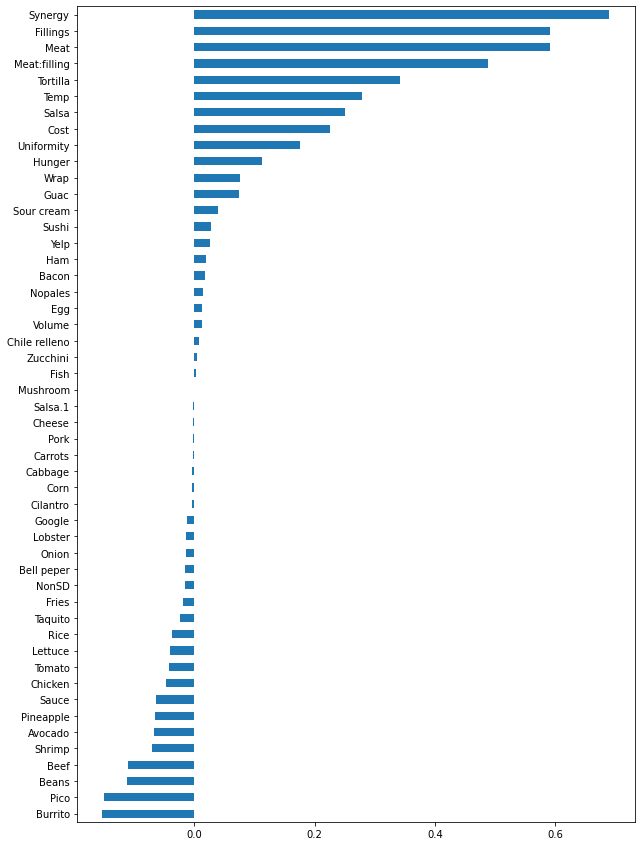

In [91]:
coefs = pd.Series(log_reg.coef_[0], X_train_imp.columns)

fig = plt.figure(figsize=(10,15))
coefs.sort_values().plot.barh();

###Limit to 'top' features by their coefficients (both positive and negative)

About the same accuracy on validation set

In [92]:
features = ['Synergy', 'Fillings', 'Meat', 'Tortilla', 'Cost', 'Beef', 'Beans', 'Pico', 'Burrito']

log_reg2 = LogisticRegressionCV(solver='lbfgs', )
log_reg2.fit(X_train_imp[features], y_train)

y_predicts2 = log_reg2.predict(X_val_imp[features])
accuracy = accuracy_score(y_val, y_predicts2)
print(f'Accuracy score = {accuracy * 100}%')

Accuracy score = 85.88235294117646%


###'Synergy' had the greatest weight alone

So try that as a single feature, but accuracy even lower

In [93]:
log_reg3 = LogisticRegressionCV(solver='lbfgs', )
log_reg3.fit(X_train_imp[['Synergy']], y_train)

y_predicts3 = log_reg3.predict(X_val_imp[['Synergy']])
accuracy = accuracy_score(y_val, y_predicts3)
print(f'Accuracy score = {accuracy * 100}%')

Accuracy score = 81.17647058823529%


### Just the numeric, non-binary features

Better than the second and third model, but not as good as the first.

In [94]:
non_binary_features = ['Burrito', 'Yelp', 'Google', 'Cost', 'Hunger', 'Volume', 'Tortilla',
       'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa',
       'Synergy', 'Wrap']

log_reg4 = LogisticRegressionCV(solver='lbfgs', )
log_reg4.fit(X_train_imp[non_binary_features], y_train)

y_predicts4 = log_reg4.predict(X_val_imp[non_binary_features])
accuracy = accuracy_score(y_val, y_predicts4)
print(f'Accuracy score = {accuracy * 100}%')

Accuracy score = 84.70588235294117%


### Scale the non-binary features

Has the best score of all

In [95]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp[non_binary_features]),
                                    columns=non_binary_features)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_imp[non_binary_features]),
                                     columns=non_binary_features)

log_reg5 = LogisticRegressionCV(solver='lbfgs')
log_reg5.fit(X_train_scaled[non_binary_features], y_train)

y_predicts5 = log_reg5.predict(X_val_scaled[non_binary_features])
accuracy = accuracy_score(y_val, y_predicts5)
print(f'Accuracy score = {accuracy * 100}%')

Accuracy score = 88.23529411764706%


Plot the coefficients

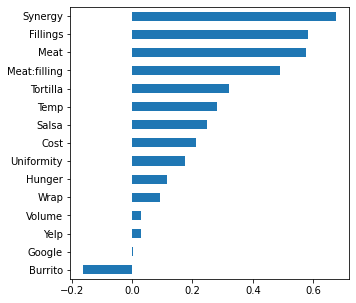

In [96]:
coefs2 = pd.Series(log_reg5.coef_[0], X_train_scaled.columns)

fig = plt.figure(figsize=(5,5))
coefs2.sort_values().plot.barh();

Yelp reviews seem to carry more weight than Google reviews. Interesting.

###Join the scaled non-binary features with the unscaled binary features, see if it is improved.

It's not. Back to the accuracy of the first model

In [0]:
binary_features = X_train_imp.columns[15:]
X_train_full = X_train_scaled.join(X_train_imp[binary_features], how='outer')
X_val_full = X_val_scaled.join(X_val_imp[binary_features], how='outer')

In [98]:
log_reg6 = LogisticRegressionCV(solver='lbfgs')
log_reg6.fit(X_train_full, y_train)

y_predicts6 = log_reg6.predict(X_val_full)
accuracy = accuracy_score(y_val, y_predicts6)
print(f'Accuracy score = {accuracy * 100}%')

Accuracy score = 85.88235294117646%


###Scale all the features

Doesn't improve the score, but it decreases.

In [99]:
scaler2 = StandardScaler()
X_train_full_scaled = scaler2.fit_transform(X_train_imp)
X_val_full_scaled = scaler2.transform(X_val_imp)

log_reg7 = LogisticRegressionCV(solver='lbfgs')
log_reg7.fit(X_train_full_scaled, y_train)

y_predicts7 = log_reg7.predict(X_val_full_scaled)
accuracy = accuracy_score(y_val, y_predicts7)
print(f'Accuracy score = {accuracy * 100}%')

Accuracy score = 82.35294117647058%


##It looks like model with just the scaled non-binary features the best score on the validation set. 

88%. So we'll reproduce it with the test set. And see how it fares...

Here we go....

In [135]:
#We had already done the imputation on the test data, so we just need to filter
#to use just the non_binary_features and scale those features.
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp[non_binary_features]),
                                     columns=non_binary_features)

# log_reg5 was the model that had the 88% score on the validation set
y_test_predictions = log_reg5.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_test_predictions)
print(f'Accuracy score = {accuracy * 100}%')

Accuracy score = 76.31578947368422%


I Think I'll cry.... :(

But it's still well above the baseline.


###Digression

How does imputation affects the data, and just wondering if also there is a correlation between burrito side (as expressed in volume) and cost? Are we paying by the amount of the product?

In the histograms choosing one feature (volume), there is a big difference in the distributions between before and after imputation. Before it shows a close to normal distribution; the latter high kurtosis. 

This is with a high proportion of missing values in the Volume column (nearly 42% in the training set) being replaced with the mean volume for imputation.



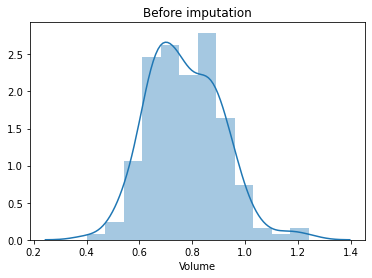

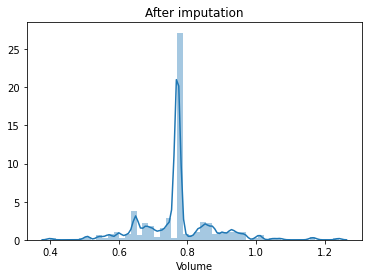

In [101]:
import seaborn as sns
sns.distplot(X_train['Volume'])
plt.title('Before imputation')
plt.show()

sns.distplot(X_train_imp['Volume'])
plt.title('After imputation')
plt.show()

In the first plot (w/o imputation), I had to manually remove NaNs from the training data, and make the resulting arrays of equal length. Admittedly "quick and dirty." Then I could calculate a trendline (using Numpy polyfit), and make a scatter plot. The trendline ended up more or less colinear with the mean cost.

The second has with the data imputed. It's much more interesting in terms of the trendline vs. the mean, but I wonder about how it creates a clump along the mean volume. The other strategies, median and mode, would just shift that clump left or right. But I wonder how that can affect a model being constructed? Yet here the results seem better.

Handling missing values seems a subtler operation than I had initially (and naively) I once thought.

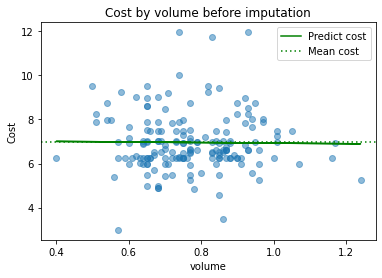

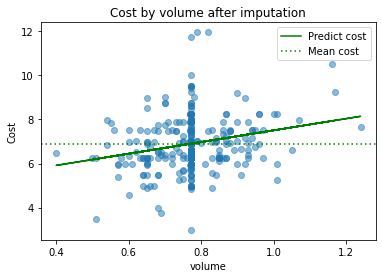

In [102]:

import numpy as np

# Drop nulls in the one missing more values, then reduce of the length of the 
# non-null values in the other column.
X = np.array(X_train['Volume'].dropna())
y = np.array(X_train['Cost'].dropna())[:len(X)]

# Get a least squares regression line
m, b = np.polyfit(X, y, deg=1)
trendline = m * X + b

# plot
plt.scatter(X, y, alpha=.5)
plt.plot(X, trendline, color='green', label='Predict cost')
plt.axhline(y.mean(), color='green', dashes=(1,2),
            label = 'Mean cost')
plt.title('Cost by volume before imputation')
plt.xlabel('volume')
plt.ylabel('Cost')
plt.legend()
plt.show()

#repeat with the imputed data
m, b = np.polyfit(X_train_imp['Volume'], X_train_imp['Cost'], deg=1)
trendline = m * X_train_imp['Volume'] + b

plt.scatter(X_train_imp['Volume'], X_train_imp['Cost'], alpha=.5)
plt.plot(X_train['Volume'], trendline, color='green', label='Predict cost')
plt.axhline(X_train_imp['Cost'].mean(), color='green', dashes=(1,2),
            label = 'Mean cost')
plt.title('Cost by volume after imputation')
plt.xlabel('volume')
plt.ylabel('Cost')
plt.legend()
plt.show()

###Using selectKBest to find optimum features

In [0]:
from sklearn.feature_selection import SelectKBest, f_classif


In [0]:
from sklearn.feature_selection import SelectKBest, f_classif

def getBest(X_train, X_val, y_train, y_val, k):
  '''
  Given a value for k, find best set of k features.
  Inputs: X and y train and validation sets
  Output: the choice of columns and estimated accuracy
  '''

  # Do the selection
  selector = SelectKBest(score_func=f_classif, k=k)
  selector.fit(X_train, y_train)
  columns = X_train.columns[selector.get_support()].tolist()

  # try it out and get the score
  model = LogisticRegressionCV()
  model.fit(X_train[columns], y_train)
  y_hat = model.predict(X_val[columns])
  accuracy = accuracy_score(y_val, y_hat)
  
  return columns, accuracy

Just a guess at the right number of features (k). We'll guess 5.

In [113]:
best = getBest(X_train_imp, X_val_imp, y_train, y_val, 5)
print(f'Selected features:\n{best[0]}\nAccuracy = {best[1] * 100}%')

Selected features:
['Meat', 'Fillings', 'Meat:filling', 'Salsa', 'Synergy']
Accuracy = 84.70588235294117%


But since we have a computer, why not just see if it can't be found algorithmically.

In [0]:
def getKs(X_train, X_val, y_train, y_val, max_k):
  '''
  Iterate through k = 1 to max_k (inclusive) and find best scored set
  of features.

  Input: X, y train and validation sets
  Output: Scores (in case one wants to plot them), the best pick of
  features, and the estimated score on validation data.
  '''

  #Loop through k values and get results
  accuracies = []
  feature_sets = {}
  for k in range(1, max_k + 1):
    best = getBest(X_train, X_val, y_train, y_val, k)
    feature_sets[k] = best[0]
    accuracies.append(best[1])

  # Find the best feature set and it's score
  maximum = np.argmax(accuracies)
  best_set = feature_sets[maximum + 1]
  best_acc = accuracies[maximum]

  return accuracies, best_set, best_acc


In [153]:
# Try k values from 1 to the number of features in the dataset
output = getKs(X_train_imp, X_val_imp, y_train, y_val, X_train_imp.shape[1])
print(f'I think your best bet is to use these features:\n{output[1]}\n',
      f'With accuracy of {output[2] * 100}%')

I think your best bet is to use these features:
['Meat', 'Fillings', 'Meat:filling', 'Synergy']
 With accuracy of 92.94117647058823%


In [123]:
# OK we'll take the tip
columns = output[1]
model = LogisticRegressionCV()
model.fit(X_train_imp[columns], y_train)
y_hat = model.predict(X_val_imp[columns])
accurcy = accuracy_score(y_val, y_hat)
print(f'Accuracy = {accurcy * 100}%')

Accuracy = 92.94117647058823%


93% on the validation set, so try the test set

In [124]:
y_pred = model.predict(X_test_imp[columns])
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy on test = {acc * 100}%')

Accuracy on test = 76.31578947368422%


Same old crap.

###But consider this!

The splits between training, validation, and test sets may **not be random samples of the data**. 

So let's start over, and try with randomly sampling for splitting the data into training, validation, and test sets. Same process:

1) Split each into X and y  
2) Impute values in each X  
3) Use selectKbest to find optimal set of features in training set  
4) Train the model on the imputed test predictors of those features  
5) Get accuracy on the validation set



In [139]:
from sklearn.model_selection import train_test_split

# Start with the original cleaned dataset
new_X = df.drop('Great', axis=1)
new_y = df['Great']

# We won't need date here
new_X.drop('Date', axis=1, inplace=True)

# Split into training and testing, then split training again into training and
# validation sets. We should have a ratio of 60%, 20%, 20% roughly.
new_X_train, new_X_test, new_y_train, new_y_test = \
              train_test_split(new_X, new_y, test_size=0.2, random_state=42)
new_X_train, new_X_val, new_y_train, new_y_val = \
              train_test_split(new_X_train, new_y_train, test_size=0.25, random_state=42)

new_X_train.shape, new_X_val.shape, new_X_test.shape

((252, 50), (84, 50), (85, 50))

In [140]:
new_y_train.shape, new_y_val.shape, new_y_test.shape

((252,), (84,), (85,))

In [0]:
# Impute values in the X's
new_imputer = SimpleImputer()
new_X_train_imp = pd.DataFrame(new_imputer.fit_transform(new_X_train), columns=new_X_train.columns)
new_X_val_imp = pd.DataFrame(new_imputer.transform(new_X_val), columns=new_X_val.columns)

# Ready for final test
new_X_test_imp = pd.DataFrame(new_imputer.transform(new_X_test), columns=new_X_test.columns)

In [142]:
new_X_train_imp.head()

,Burrito,Yelp,Google,Cost,Hunger,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,1.0,0.0,0.0,5.79,4.0,0.784756,4.0,3.0,4.0,2.5,3.5,4.0,2.0,2.5,5.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,5.99,2.0,0.740000,2.0,2.5,4.0,3.0,4.0,3.5,3.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,0.0,7.90,3.5,0.930000,4.0,3.5,4.5,4.5,3.5,3.5,3.5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,4.99,3.5,0.750000,2.5,4.5,3.0,2.5,3.0,3.0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,6.50,4.5,0.830000,4.5,3.0,3.5,4.5,3.5,4.0,3.5,4.3,4.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [152]:
# Use function above to find best set of columns using selectKBest
the_best = getKs(new_X_train_imp, new_X_val_imp, new_y_train, new_y_val, new_X_train.shape[1])
print(f'I think your best bet is to use these features:\n{the_best[1]}\n',
      f'With accuracy of {the_best[2] * 100}%')


I think your best bet is to use these features:
['Cost', 'Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Beans']
 With accuracy of 91.66666666666666%


In [150]:
# OK we'll take the tip
columns = the_best[1]
best_model = LogisticRegressionCV()
best_model.fit(new_X_train_imp[columns], new_y_train)
y_hat = best_model.predict(new_X_val_imp[columns])
accurcy = accuracy_score(new_y_val, y_hat)
print(f'Accuracy = {accurcy * 100}%')

Accuracy = 91.66666666666666%


And we'll just go for the gold?

In [151]:
y_pred = best_model.predict(new_X_test_imp[columns])
acc = accuracy_score(new_y_test, y_pred)
print(f'Accuracy on test = {acc * 100}%')

Accuracy on test = 81.17647058823529%


Plot the coefficients for our 'best model'

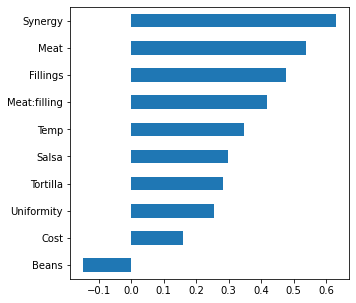

In [156]:
coefs3 = pd.Series(best_model.coef_[0], new_X_val_imp[columns].columns)

fig = plt.figure(figsize=(5,5))
coefs3.sort_values().plot.barh();

###Better!